<a href="https://colab.research.google.com/github/NouranShaaban/workshop_geopython2019/blob/master/lastisaCopy_of_Copy_of_Copy_of_SemanticSegTrial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
import tensorflow_addons as tfa
import glob
import numpy as np
from PIL import Image

In [ ]:
# Set the directory where the images are stored
image_dir = '/content/drive/MyDrive/DATASET/newlabels_train/JPEGImages'

# Create an empty list to store the image data
image_data = []

# Use glob to get a list of all the image filenames
filenames = glob.glob(image_dir + '/*.jpg')

# Loop through the filenames and load the images
for filename in filenames:
    # Load the image and convert it to grayscale
    image = Image.open(filename).convert('L')
  
    # Resize the image to a consistent size
    image = image.resize((256, 256))
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Append the image array to the list
    image_data.append(image_array)

# Convert the list of image arrays to a NumPy array
image_data = np.array(image_data)

# Save the image data to a file
np.save('image_data.npy', image_data)

In [ ]:
image_data = image_data.reshape((-1,256,256,1))


In [ ]:
# Set the directory where the images are stored
label_dir = '/content/drive/MyDrive/DATASET/newlabels_train/SegmentationClassPNG'

# Create an empty list to store the image data
label_data = []
# Number of classes
num_classes = 4

# Use glob to get a list of all the image filenames
filenames = glob.glob(label_dir + '/*.png')

# Loop through the filenames and load the images
for filename in filenames:
    # Load the image and convert it to grayscale
    label = Image.open(filename)#.convert('L')
    
    # Resize the image to a consistent size
    label = label.resize((256, 256))
    # Convert the image to a numpy array
    label_array = np.array(label)
 
    
    # Append the image array to the list
    label_data.append(label_array)

label_data = np.array(label_data)

# Save the image data to a file
np.save('label_data.npy', label_data)

##########################################################################

In [ ]:
label_data.size

983040

In [ ]:

one_hot_labels = np.zeros((len(label_data), 256, 256, num_classes))

# Iterate over the label images
for i, label_image in enumerate(label_data):
    # one-hot encode the labels
    one_hot_labels[i] = np.eye(num_classes)[label_image]

    class_names = ['Background','panel','panelWfrost','Thicknow']

# Get the index of the class with the highest probability
label_index = np.argmax(one_hot_labels, axis=-1)

# Get the name of the class
label_index = label_index.astype(int)
class_name = np.vectorize(lambda x: class_names[x])(label_index)


In [ ]:
one_hot_labels.shape

(15, 256, 256, 4)

In [ ]:
one_hot_labels[0,:,:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

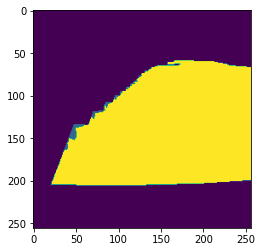

In [ ]:
# Load the image data
label_data = np.load('label_data.npy')

# Number of classes
num_classes = 4

# Create an empty array to store the one-hot encoded labels
one_hot_labels = np.zeros((len(label_data), 256, 256, num_classes))

# Iterate over the label images
for i, label_image in enumerate(label_data):
    # One-hot encode the labels
    for j in range(num_classes):
        one_hot_labels[i,:,:,j] = (label_image == j)

# Get the index of the class with the highest probability
label_index = np.argmax(one_hot_labels, axis=-1)

# Get the name of the class
class_names = ['Background','panel','panelWfrost','Thicksnow']

# display the one-hot encoded image
img = label_index[1]
plt.imshow(img)
plt.show()


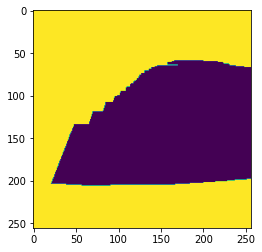

In [ ]:
class_3 = np.where(label_index[2] == 0, 1,0)
class_3 = class_3.reshape((256,256))
plt.imshow(class_3)
plt.show()


In [ ]:
class_counts = []
for i in range(num_classes):
    class_mask = np.where(label_index[2] == i, 1, 0)
    class_counts.append(np.sum(class_mask))

In [ ]:
print(class_counts)

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # add another Conv2D layer
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
 # inputs
import tensorflow.keras.layers as layers
 
inputs = layers.Input(shape=(256,256,1))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 64)
# 2 - downsample
f2, p2 = downsample_block(p1, 128)
# 3 - downsample
f3, p3 = downsample_block(p2, 256)
# 4 - downsample
f4, p4 = downsample_block(p3, 512)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 1024)

# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 512)
# 7 - upsample
u7 = upsample_block(u6, f3, 256)
# 8 - upsample
u8 = upsample_block(u7, f2, 128)
# 9 - upsample
u9 = upsample_block(u8, f1, 64)

# outputs
outputs = layers.Conv2D(4, 1, padding="same", activation = "softmax")(u9)

# unet model with Keras Functional API
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")


In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

x = unet_model.outputs

# Compile the model
unet_model = keras.Model(inputs, x)
unet_model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
image_data.shape

(15, 256, 256, 1)

In [ ]:


from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(image_data, one_hot_labels, test_size=0.2, random_state=42)

In [ ]:
train_labels.shape

In [ ]:
train_images.shape

(12, 256, 256, 1)

In [ ]:
test_labels.shape


(3, 256, 256, 4)

In [ ]:
test_labels.shape

(3, 256, 256, 4)

In [ ]:
history = unet_model.fit(datagen.flow(train_images, train_labels, batch_size=7), epochs=15, validation_data=(test_images, test_labels))


Epoch 1/15
2/2 [==============================] - 227s 100s/step - loss: 4637.9893 - accuracy: 0.3236 - val_loss: 64.3944 - val_accuracy: 0.3564
Epoch 2/15
2/2 [==============================] - 209s 98s/step - loss: 96.7451 - accuracy: 0.2917 - val_loss: 81.9093 - val_accuracy: 0.3607
Epoch 3/15
2/2 [==============================] - 206s 98s/step - loss: 96.3907 - accuracy: 0.2936 - val_loss: 58.4070 - val_accuracy: 0.3635
Epoch 4/15
2/2 [==============================] - 209s 131s/step - loss: 66.7411 - accuracy: 0.2912 - val_loss: 30.4648 - val_accuracy: 0.3514
Epoch 5/15
2/2 [==============================] - 190s 86s/step - loss: 42.0521 - accuracy: 0.2910 - val_loss: 19.1663 - val_accuracy: 0.3638
Epoch 6/15
2/2 [==============================] - 199s 124s/step - loss: 24.2720 - accuracy: 0.2953 - val_loss: 11.0395 - val_accuracy: 0.3606
Epoch 7/15
2/2 [==============================] - 205s 96s/step - loss: 15.0031 - accuracy: 0.2956 - val_loss: 9.3254 - val_accuracy: 0.3371
Ep

In [ ]:
unet_model.save('unet_model.h5')

In [ ]:
import cv2 # Load the test image in color format
test_image = cv2.imread('test_image.jpg')

# Resize the test image to the desired size
test_image = cv2.resize(test_image, (256, 256))

# Convert the test image to grayscale
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Preprocess the test image
gray_image = gray_image.astype('float32') / 255.0

# Reshape the grayscale image to match the model input shape
gray_image = gray_image.reshape((1, 256, 256, 1))

# Make predictions on the test image
predictions = unet_model.predict(gray_image)

In [ ]:
print(predictions)

In [ ]:
temp=[]
for i in range(0,255):
    for j in range (0,255):
        temp.append(np.argmax(predictions[0,i,j]))
temp=np.array(temp)
unique, counts = np.unique(temp, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
print(counts[0])